## Imports

In [3]:
import warnings
warnings.filterwarnings("ignore")

## for data
import numpy as np
import pandas as pd
import joblib 

from config import(my_scoring, 
                   metric_name, 
                   experiment_id, 
                   models)

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as impipeline

#  sklearn imports
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier

# model_selectin imports
from sklearn.model_selection import (GridSearchCV, 
                                     train_test_split,
                                     learning_curve, 
                                     cross_val_score)

# metrics imports
from sklearn.metrics import(accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve,
                            roc_auc_score, 
                            make_scorer, 
                            r2_score, 
                            fbeta_score,
                            confusion_matrix, 
                            classification_report, )

# ensample imports 
from sklearn.ensemble import (VotingClassifier, 
                              BaggingClassifier,
                              RandomForestClassifier, 
                              GradientBoostingClassifier, 
                              GradientBoostingRegressor, 
                              AdaBoostClassifier, 
                              AdaBoostRegressor
)

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Ml Flow imports
import mlflow.sklearn
import mlflow

## Read Data

In [4]:
raw_data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

In [4]:
raw_data.shape

(5110, 12)

In [5]:
raw_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
raw_data.drop('id',axis=1, inplace=True)

In [7]:
raw_data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

BMI: <br>
Body mass index is a value derived from the `mass` and `height` of a person.<br> The BMI is defined as the body mass divided by the square of the body height.. since we don't have those values, we can predict them eaither using ML or just filling with Median/Mean

we will use the imputer in the pipeline down in the  code

## EDA

In [8]:
cols = ['age','bmi','avg_glucose_level']

<AxesSubplot:>

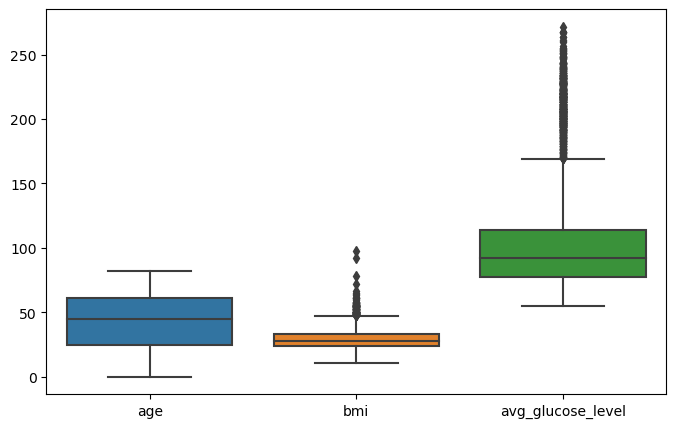

In [9]:
plt.figure(figsize=(8,5))
sns.boxplot(data= raw_data[cols] )

In [10]:
raw_data['stroke'].unique()

array([1, 0], dtype=int64)

In [11]:
q1 = raw_data[cols].quantile(0.25)
q3 = raw_data[cols].quantile(0.75)
lower_bound = q1 - 1.5 * (q3 - q1)
upper_bound = q3 + 1.5 * (q3 - q1)

raw_data_no_outliers = raw_data[(raw_data[cols] >= lower_bound) & (raw_data[cols] <= upper_bound)]

In [12]:
raw_data_no_outliers['stroke'].unique()

array([nan])

In [13]:
raw_data_no_outliers.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,NaN,67.0,NaN,NaN,NaN,NaN,NaN,NaN,36.6,NaN,NaN
1,NaN,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,80.0,NaN,NaN,NaN,NaN,NaN,105.92,32.5,NaN,NaN
3,NaN,49.0,NaN,NaN,NaN,NaN,NaN,NaN,34.4,NaN,NaN
4,NaN,79.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,NaN,NaN


we can't remove outliers..... sounds like they are not truly an outliers

<AxesSubplot:>

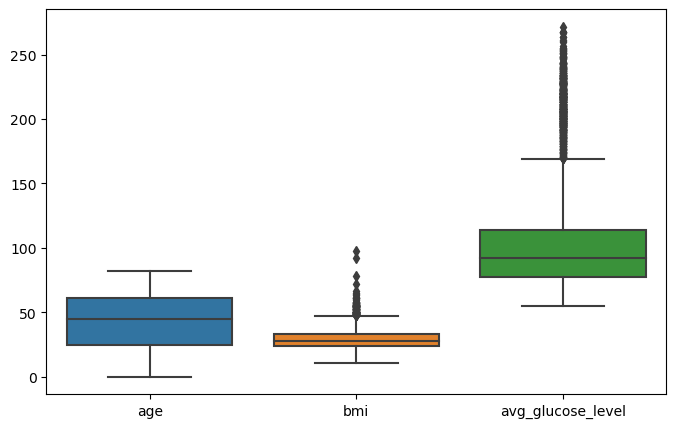

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(data= raw_data[['age','bmi','avg_glucose_level']], )

### lets see if there's balancing

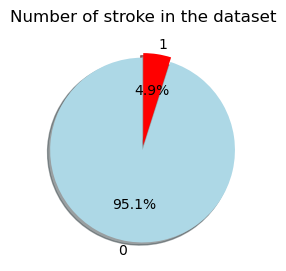

In [15]:
labels =raw_data['stroke'].value_counts(sort = True).index
sizes = raw_data['stroke'].value_counts(sort = True)

colors = ["lightblue","red"]
explode = (0.05,0) 
 
plt.figure(figsize=(3,3))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Number of stroke in the dataset')
plt.show()

#### we might have to consider using some ReSamplling algo

In [16]:
def plot_hist(col, bins=30, title="",xlabel="",ax=None):
    sns.distplot(col, bins=bins,ax=ax)
    ax.set_title(f'Histogram of {title}',fontsize=20)
    ax.set_xlabel(xlabel)

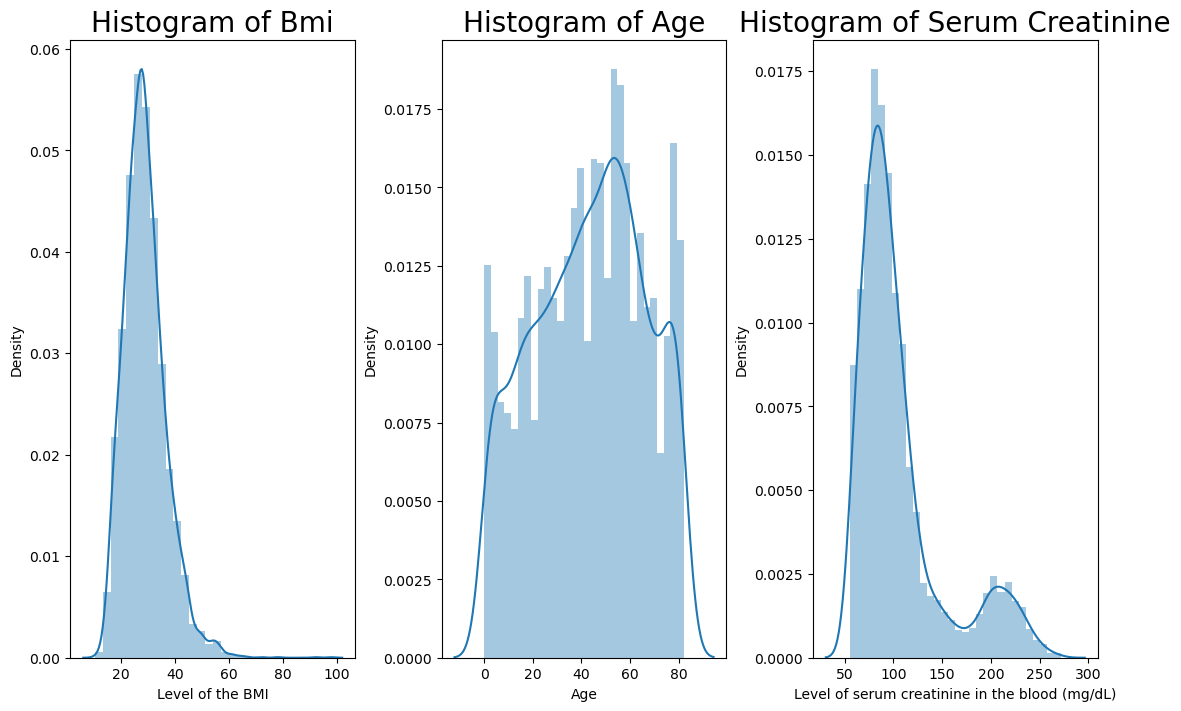

In [17]:
fig, axes = plt.subplots(1,3,figsize=(11,7),constrained_layout=True)
plot_hist(raw_data.bmi,title='Bmi',xlabel="Level of the BMI",ax=axes[0])

plot_hist(raw_data.age,bins=30,title='Age',xlabel='Age',ax=axes[1])

plot_hist(raw_data.avg_glucose_level,title='Serum Creatinine', xlabel='Level of serum creatinine in the blood (mg/dL)', ax=axes[2])

plt.show()


#### data needs to be scaled 


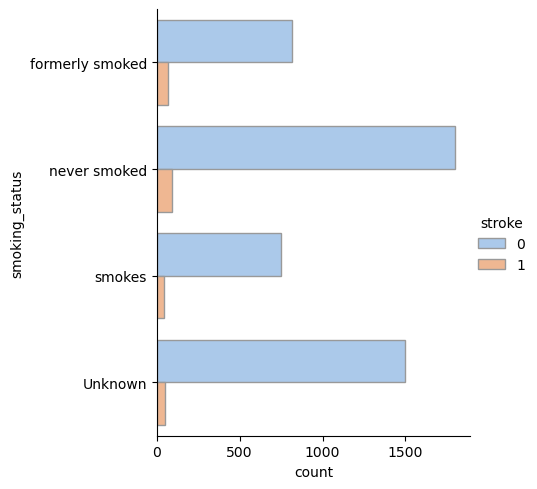

In [18]:
sns.catplot(y="smoking_status", hue="stroke", kind="count",
            palette="pastel", edgecolor=".6",
            data=raw_data)

seems that the stroke is **`not highly`** corralated to smokers since the proportion of person having a stroke is fairly the same among the other smoking status.

### Predictive Power Score (PPS)

Text(50.58159722222221, 0.5, 'target')

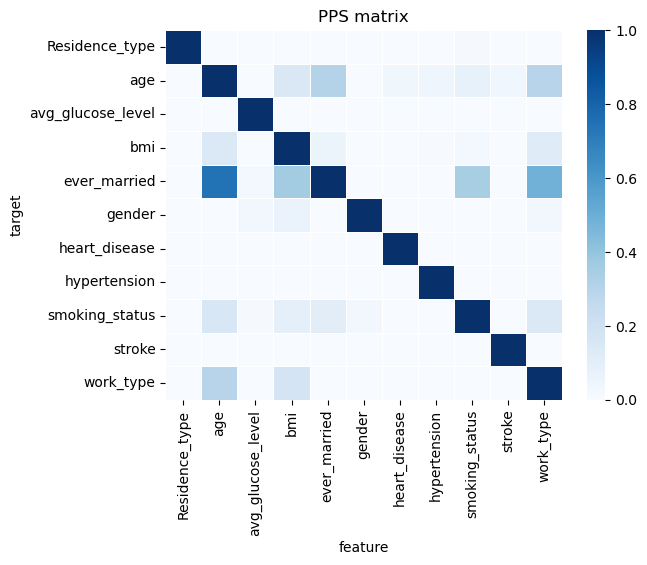

In [19]:
mat = pps.matrix(raw_data)
mat = mat[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
ax = sns.heatmap(mat, vmin=0, vmax=1, cmap="Blues", linewidths=0.5)
ax.set_title("PPS matrix")
ax.set_xlabel("feature")
ax.set_ylabel("target")

<Figure size 200x200 with 0 Axes>

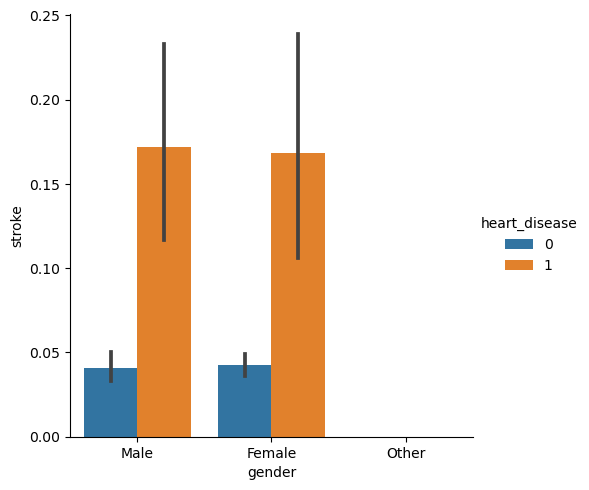

In [20]:
plt.figure(figsize=(2,2))
sns.catplot(x="gender", y="stroke", hue="heart_disease", kind="bar", data=raw_data)

in terms of gender it's not truly spreatable

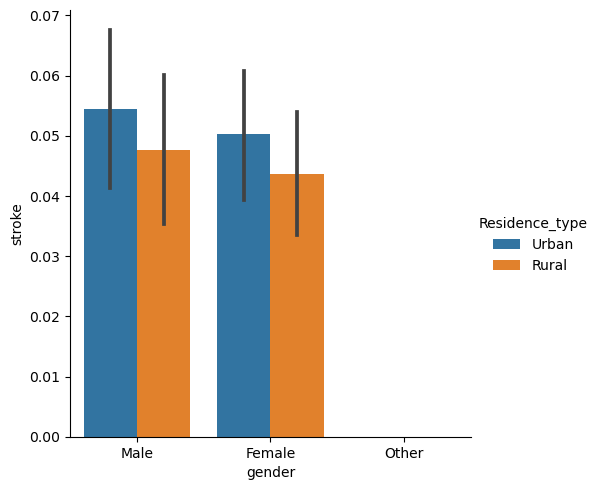

In [21]:
sns.catplot(x="gender", y="stroke", hue="Residence_type", kind="bar", data=raw_data)

sounds like Males in Urban are just a bit more likly to have strok than others

In [22]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [23]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


*`hypertension`* : it's already between 0 and 1, doesn't need scalling<br>
*`heart_disease`* : it's a binary value: 0-> don't have, 1-> have<br>
*`strok`* : also binary vlaues
*`avg_glucose_level`* : need scalling !<br>
*`bmi`* : need too<br>
*`age`* : i'd like to binning it, i will try it

## `Splitting` the data

In [8]:
features = raw_data.loc[:,:'smoking_status']
target = raw_data.loc[:,'stroke']

In [9]:
X = features
y = target
print("X.shape: {}  y.shape: {}".format(X.shape, y.shape))

X.shape: (5110, 10)  y.shape: (5110,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

## Feature preprocessing and pipeline:<br>

In [11]:
num_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status' ]

In [12]:
cat_transformer = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy= 'most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown= 'ignore', sparse= False)),
    ]
)

num_transformer = Pipeline(
    steps = [
        ('imputer', KNNImputer(n_neighbors= 5)),
        ('sclaer', StandardScaler() ),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [13]:
def train_model(classifier, resample=False):
    
    if resample:
        clf = impipeline(steps=[('preprocessor', preprocessor ),
                ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
                ('classifier', classifier)])

    else: 
        clf = Pipeline(steps=[('preprocessor', preprocessor ),
                      ('classifier', classifier)])
    return clf

In [14]:
def R2_model(model, y_true, y_predicted):
    print("R-squared scores are:\n")
    print("r2_score (linear model): {:.2f}".format(r2_score(y_true, y_predicted)))
    
    # print('score (training): {:.3f}'
    #  .format(model.score(x1, y1)))
    # print('score (test): {:.3f}'
    #     .format(model.score(x2, y2)))

## Modelling

The below cell contain the models from config.py <br> with `Tunning` and `GridSearch` 

In [32]:
cv = 5  
preprocessing_step_v0 = preprocessor

for model_name, model_params in models.items():
    with mlflow.start_run(run_name=model_name, 
                          description="this is the expermint with  outliers",
                          experiment_id= experiment_id) as run:
        mlflow.log_param("model", model_name)
        mlflow.log_param("preprocessing", "preprocessing_step_v0")
        
        # Define the pipeline with the preprocessing steps and classifier
        pipeline = impipeline([
            # edite the preprocessing
            ('preprocessing', preprocessing_step_v0),
            ('smote', SMOTE(sampling_strategy='minority', random_state=42)),
            ('classifier', model_params["estimator"])
        ])
        
        # Define the hyperparameter grid to search over
        param_grid = model_params["param_grid"]
        
        # Define the grid search object
        grid_search = GridSearchCV(pipeline, param_grid=param_grid, 
                                   cv=cv,
                                   scoring=my_scoring, 
                                   refit="auc", 
                                   n_jobs=-1)
        
        # Fit the grid search object to the data
        grid_search.fit(X_train, y_train)
        
        # Get the best estimator from the grid search
        model = grid_search.best_estimator_
        y_pred_train = model.predict(X_train)
        y_proba_train = model.predict_proba(X_train)[:, 1] # Probability of positive class
        accuracy_train = accuracy_score(y_train, y_pred_train)
        precision_train = precision_score(y_train, y_pred_train)
        recall_train = recall_score(y_train, y_pred_train)
        f1_train = f1_score(y_train, y_pred_train)
        auc_train = roc_auc_score(y_train, y_proba_train)
        f2_train = make_scorer(fbeta_score, beta=2)(model, X_train, y_train)


        y_pred_test = model.predict(X_test)
        y_proba_test = model.predict_proba(X_test)[:, 1] # Probability of positive class
        accuracy_test = accuracy_score(y_test, y_pred_test)
        precision_test = precision_score(y_test, y_pred_test)
        recall_test = recall_score(y_test, y_pred_test)
        f1_test = f1_score(y_test, y_pred_test)
        auc_test = roc_auc_score(y_test, y_proba_test)
        f2_test = make_scorer(fbeta_score, beta=2)(model, X_test, y_test)


        # Step 6: Plot all matrices
        mlflow.log_metric("accuracy_train", accuracy_train)
        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("f1_score_train", f1_train)
        mlflow.log_metric("auc_train", auc_train)
        mlflow.log_metric("f2_score_train", f2_train)
        mlflow.log_metric("accuracy_test", accuracy_test)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_test", recall_test)
        mlflow.log_metric("f1_score_test", f1_test)
        mlflow.log_metric("auc_test", auc_test)
        mlflow.log_metric("f2_score_test", f2_test)        
        
        # Log the best hyperparameters
        mlflow.log_params(grid_search.best_params_)
    
    joblib.dump(grid_search.best_estimator_, f'models/best_estimator_{model_name}.pkl')


get the top models

In [36]:
N = 10
runs = mlflow.search_runs(experiment_ids=experiment_id)
runs = runs.sort_values(by=["metrics."+metric_name], ascending=False)
best_runs = runs.head(N)
best_runs[["run_id", "metrics."+metric_name]]
best_runs["model_name"] = best_runs["tags.mlflow.runName"]
best_runs[["run_id", "model_name","metrics.accuracy_test", "metrics.precision_test", 'metrics.recall_test']]

,run_id,model_name,metrics.accuracy_test,metrics.precision_test,metrics.recall_test
3,69cb295af1c34d36ac0ae6b4f7301a91,logistic_regression,0.743640,0.141892,0.84
0,95b71e0bbe32408088be43b515d7bae3,gradient_boosted_trees,0.682975,0.117318,0.84
2,d8caa1d0604f4d7c9cda442821751623,random_forest,0.717221,0.115756,0.72
1,7184589359574398a05ba645fb16061d,decision_tree,0.666341,0.114058,0.86


all the data columns(metricses)

**let's plot the AUC to observe the best model:**

In [5]:
models_joblib= [
  {
    'label': 'decision_tree',
    'name': 'models/best_estimator_decision_tree.pkl'
  },
  {
    'label': 'logistic_regression',
    'name': 'models/best_estimator_logistic_regression.pkl'
  },
  {
    'label': 'random_forest',
    'name': 'models/best_estimator_random_forest.pkl'
  },
  {
    'label': 'gradient_boosted_trees',
    'name': 'models/best_estimator_gradient_boosted_trees.pkl'
  },
  {
    'label': 'k_nearest_neighbors',
    'name': 'models/best_estimator_k_nearest_neighbors.pkl'
  }
]

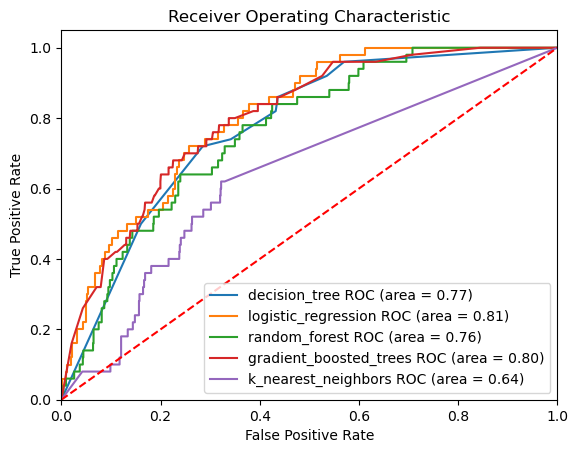

In [15]:
plt.figure()
for m in models_joblib:
  model = joblib.load(m['name'])
  model.fit(X_train, y_train)
  y_pred = model.predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'r--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


### Plotting for best estimator models the learning curve:

In [39]:
cv = 5

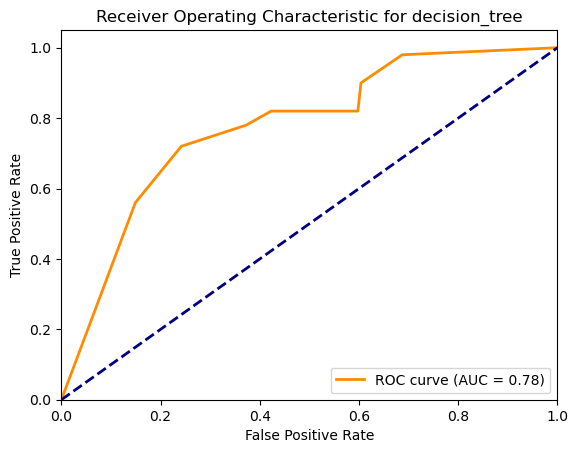

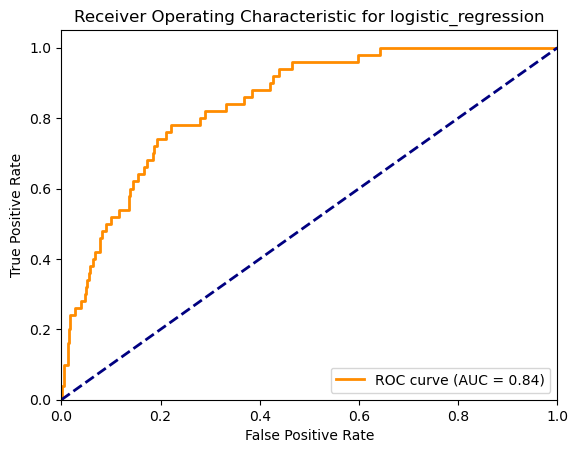

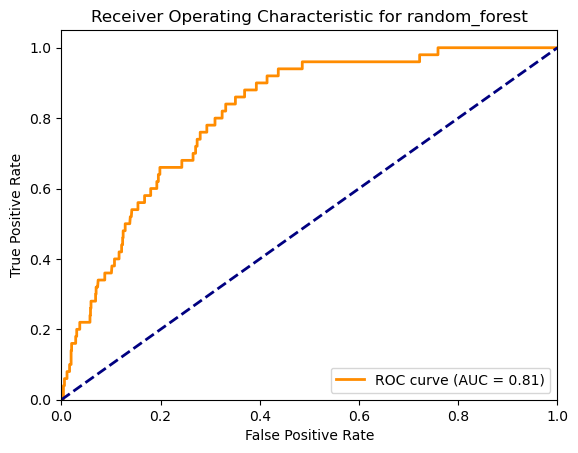

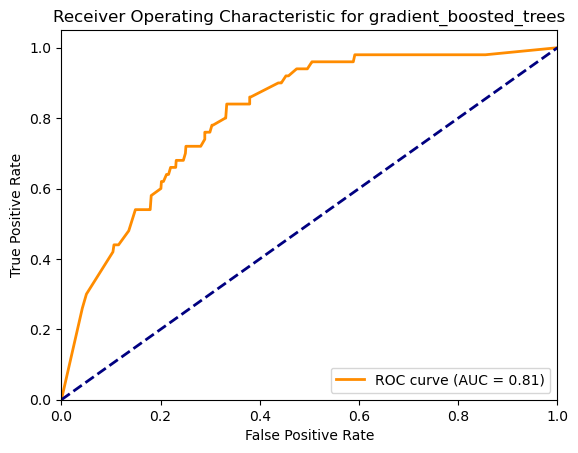

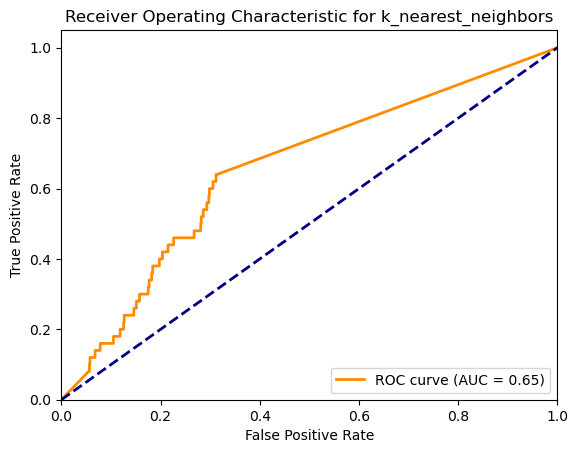

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_pred_prob = model.predict_proba(X_test)[:, 1]

for m in models_joblib:
    model = joblib.load(m['name'])
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for '+m['label'])
    plt.legend(loc="lower right")
    plt.savefig('figuers/'+m['label']+'_ROC.png')
    plt.show()

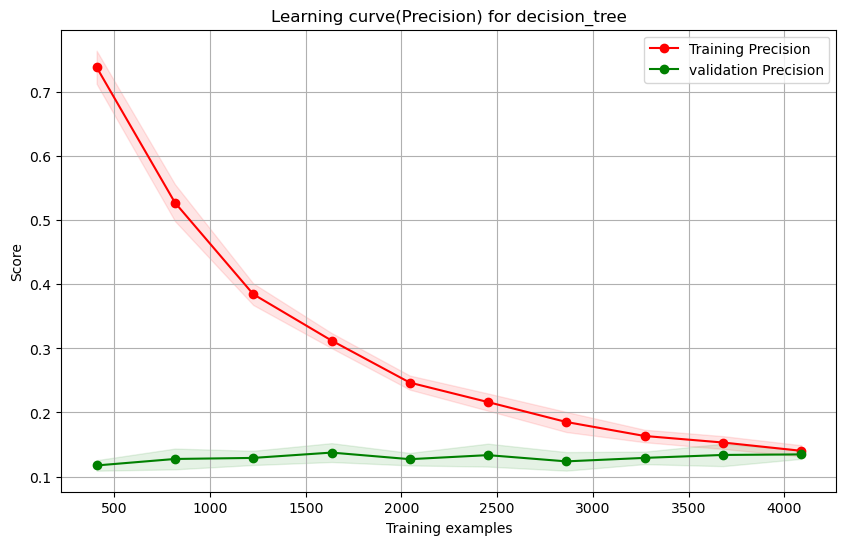

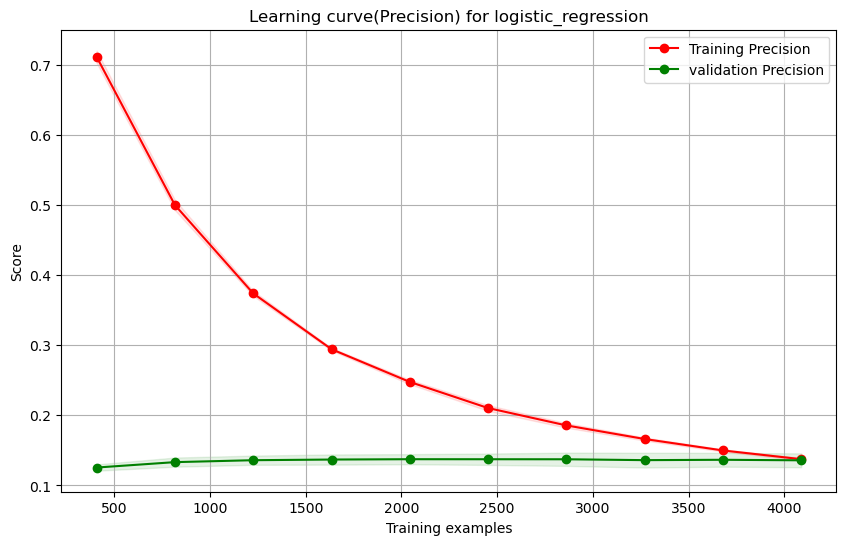

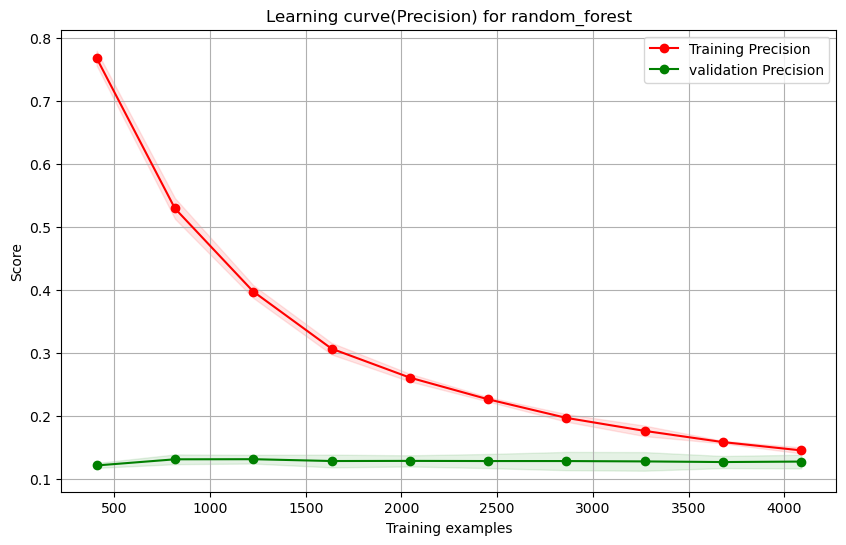

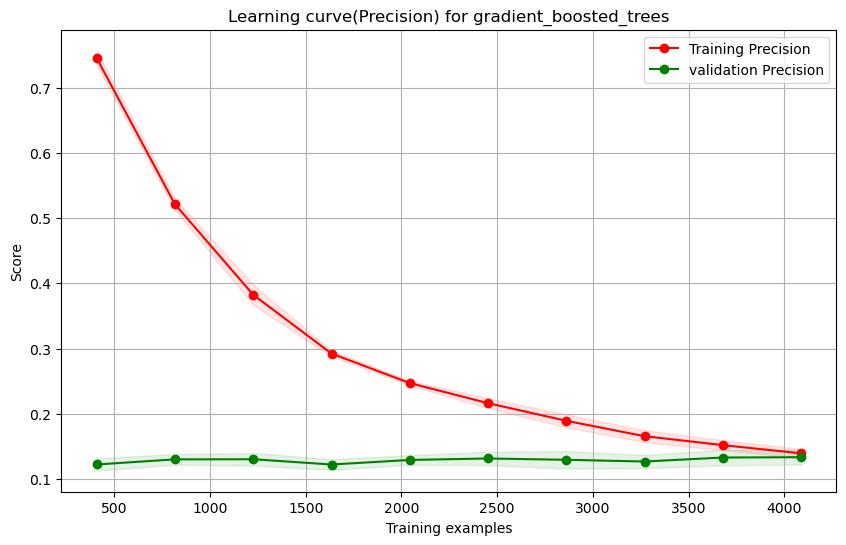

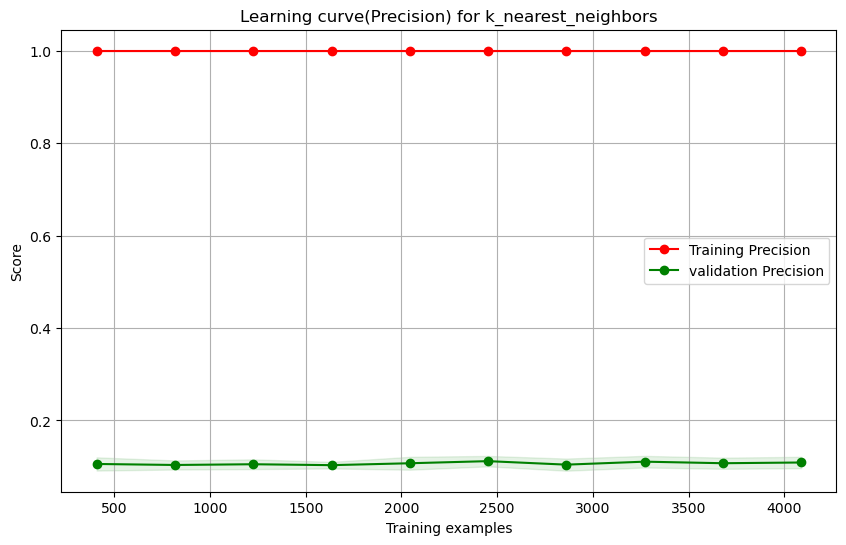

In [42]:
train_sizes = np.linspace(0.1, 1.0, 10)

for m in models_joblib:
    model = joblib.load(m['name'])
    model.fit(X_train, y_train)
    train_sizes, train_scores, validation_scores = learning_curve(model, X, y, train_sizes=train_sizes, cv=cv, scoring='precision', n_jobs=-1)
    # Compute the mean and standard deviation of the training and validation scores for each training set size
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)
    # plotting 
    plt.figure(figsize=(10, 6))
    plt.title(f'Learning curve(Precision) for ' + m['label'])
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Precision')
    plt.plot(train_sizes, validation_scores_mean, 'o-', color='g', label='validation Precision')
    
    plt.legend(loc="best")
    plt.savefig('figuers/'+m['label']+'_Precision_learning_curve.png')
    plt.show()


`Load` the best models

In [43]:
LRmodel = joblib.load('models/best_estimator_logistic_regression.pkl')
DTmodel = joblib.load('models/best_estimator_decision_tree.pkl')
RFmodel = joblib.load('models/best_estimator_random_forest.pkl')
GBmodel = joblib.load('models/best_estimator_gradient_boosted_trees.pkl')
KNNmodel = joblib.load('models/best_estimator_k_nearest_neighbors.pkl')

## Ensamble learning

### voting

In [57]:
voting_clf = VotingClassifier(
    estimators=[('lr', LRmodel), ('dt', GBmodel)],
    voting='hard')

because the voting is hard -> we can't calculate the auc

In [60]:
with mlflow.start_run(run_name="voting_LR_GB",
                      experiment_id= experiment_id ) as run:
   
   voting_clf.fit(X_train,y_train) 

   y_pred_train = voting_clf.predict(X_train)
   accuracy_train = accuracy_score(y_train, y_pred_train)
   precision_train = precision_score(y_train, y_pred_train)
   recall_train = recall_score(y_train, y_pred_train)
   f1_train = f1_score(y_train, y_pred_train)
   f2_train = make_scorer(fbeta_score, beta=2)(voting_clf, X_train, y_train)


   y_pred_test = voting_clf.predict(X_test)
   accuracy_test = accuracy_score(y_test, y_pred_test)
   precision_test = precision_score(y_test, y_pred_test)
   recall_test = recall_score(y_test, y_pred_test)
   f1_test = f1_score(y_test, y_pred_test)
   f2_test = make_scorer(fbeta_score, beta=2)(voting_clf, X_test, y_test)


   # Step 6: Plot all matrices
   mlflow.log_metric("accuracy_train", accuracy_train)
   mlflow.log_metric("precision_train", precision_train)
   mlflow.log_metric("recall_train", recall_train)
   mlflow.log_metric("f1_score_train", f1_train)
   mlflow.log_metric("f2_score_train", f2_train)
   mlflow.log_metric("accuracy_test", accuracy_test)
   mlflow.log_metric("precision_test", precision_test)
   mlflow.log_metric("recall_test", recall_test)
   mlflow.log_metric("f1_score_test", f1_test)
   mlflow.log_metric("f2_score_test", f2_test)
   
joblib.dump(voting_clf, f'models/voting_LR_GB.pkl')

['voting_LR_GB.pkl']

### bagging classifier

In [73]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

In [74]:
bag_clf = train_model(bag_clf, True)

In [76]:
with mlflow.start_run(run_name="bag_LR", experiment_id= experiment_id) as run:
   
   bag_clf.fit(X_train,y_train) 
   y_pred_train = bag_clf.predict(X_train)
   y_proba_train = bag_clf.predict_proba(X_train)[:, 1] # Probability of positive class
   accuracy_train = accuracy_score(y_train, y_pred_train)
   precision_train = precision_score(y_train, y_pred_train)
   recall_train = recall_score(y_train, y_pred_train)
   f1_train = f1_score(y_train, y_pred_train)
   auc_train = roc_auc_score(y_train, y_proba_train)
   f2_train = make_scorer(fbeta_score, beta=2)(bag_clf, X_train, y_train)


   y_pred_test = bag_clf.predict(X_test)
   y_proba_test = bag_clf.predict_proba(X_test)[:, 1] # Probability of positive class
   accuracy_test = accuracy_score(y_test, y_pred_test)
   precision_test = precision_score(y_test, y_pred_test)
   recall_test = recall_score(y_test, y_pred_test)
   f1_test = f1_score(y_test, y_pred_test)
   auc_test = roc_auc_score(y_test, y_proba_test)
   f2_test = make_scorer(fbeta_score, beta=2)(bag_clf, X_test, y_test)


   # Step 6: Plot all matrices
   mlflow.log_metric("accuracy_train", accuracy_train)
   mlflow.log_metric("precision_train", precision_train)
   mlflow.log_metric("recall_train", recall_train)
   mlflow.log_metric("f1_score_train", f1_train)
   mlflow.log_metric("auc_train", auc_train)
   mlflow.log_metric("f2_score_train", f2_train)
   mlflow.log_metric("accuracy_test", accuracy_test)
   mlflow.log_metric("precision_test", precision_test)
   mlflow.log_metric("recall_test", recall_test)
   mlflow.log_metric("f1_score_test", f1_test)
   mlflow.log_metric("auc_test", auc_test)
   mlflow.log_metric("f2_score_test", f2_test)        

   
joblib.dump(voting_clf, f'models/bag_DT.pkl')

['bag_DT.pkl']

In [84]:
model_voting =  {
    'label': 'voting_LR_GB',
    'name': 'models/voting_LR_GB.pkl'
  }

In [85]:
model_bagging =  {
    'label': 'bagging_DT',
    'name': 'models/bag_DT.pkl'
  }

In [91]:
ensamble = [model_voting, model_bagging]

In [105]:
for m in ensamble:
    model = joblib.load(m['name'])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(m['label'] + '\n')
    print(report+ '\n' + '-------------------------')

voting_LR_GB

              precision    recall  f1-score   support

           0       0.99      0.75      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.78      0.55      1022
weighted avg       0.95      0.75      0.82      1022

-------------------------
bagging_DT

              precision    recall  f1-score   support

           0       0.99      0.75      0.85       972
           1       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.78      0.55      1022
weighted avg       0.95      0.75      0.82      1022

-------------------------
